<center> <h1> PROJECT : "SPARK with PySpark" </h1> </center>

<center> <h2> Recommendation System on Music Artists </h2> </center>

<center> <h3> 2019/12/26 </h3> </center>

<center> <h3> Kaelig Castor </h3> </center>

<p style='text-align: justify;'> <b> 
This notebook uses a music streaming database to build a recommendation system.
<br> 
<br>
The dataset consists in 3 files :
    
- **`user_artist_data.txt`**: About 140,000+ unique users, and 1.6 million unique artists. About 24.2 million users' plays of artists' are recorded, along with their count (3 columns separated by spaces) : 

| UserID | ArtistID | PlayCount |
|----|----|----|
| ...|...|...|


- **`artist_data.txt`** : Names of each artist by their IDs (2 columns separated by tab characters (`\t`)) :

| ArtistID | Name |
|---|---|
|...|...|

- **`artist_alias.txt`**: The artist's name can be misspelled and may be distinct artist IDs in the data set. `artist_alias.txt` maps artist IDs that are known misspellings (2 columns separated by tab characters (`\t`)) :

| MisspelledArtistID | StandardArtistID |
|---|---|
|...|...|

</p> </b> 

Unlike an **explicit** rating dataset which contains information about users' preference for products, the datasets used here only has information about events: specifically, it keeps track of how many times a user played songs of a given artist and the names of artists. In the literature, this is called **implicit** rating.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
local_path='/content/drive/My Drive/SD701/'
os.chdir(local_path)
!pwd

Mounted at /content/drive
/content/drive/My Drive/SD701


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.1/spark-2.4.1-bin-hadoop2.7.tgz
!ls
!mv spark-3.0.0-preview2-bin-hadoop2.7.tgz.2 spark-3.0.0-preview2-bin-hadoop2.7.tgz
!ls
!tar xf spark-3.0.0-preview2-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64/"  
os.environ["SPARK_HOME"] = "/content/drive/My Drive/SD701/spark-3.0.0-preview2-bin-hadoop2.7"  
import findspark
findspark.init()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import sys
import re
import random
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
%matplotlib inline
from time import time
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [5]:
os.chdir(local_path)
!pwd

/content/drive/My Drive/SD701


In [14]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.shuffle.partitions","5")

In [15]:
spark

In [21]:
customSchemaArtists = StructType([ \
    StructField("artistid", IntegerType(), True), \
    StructField("name", StringType(), True)])
artists = spark.read.csv('./dataset_artist/artist_data.txt', sep='\t', schema = customSchemaArtists)
aliases = spark.read.csv('./dataset_artist/artist_alias.txt', sep='\t', inferSchema=True)
aliases = aliases.withColumnRenamed("_c0", "mispelledid").withColumnRenamed("_c1", "artistid")
data = spark.read.csv('./dataset_artist/user_artist_data.txt', sep=' ', inferSchema = True)
data = data.withColumnRenamed("_c0", "userid").withColumnRenamed("_c1", "artistid").withColumnRenamed("_c2", "plays")

In [24]:
data.describe().show()

+-------+------------------+------------------+-----------------+
|summary|            userid|          artistid|            plays|
+-------+------------------+------------------+-----------------+
|  count|          24296858|          24296858|         24296858|
|   mean|1947573.2653533637|1718704.0937568964|15.29576248089362|
| stddev| 496000.5551819132| 2539389.092428355|153.9153244697963|
|    min|                90|                 1|                1|
|    max|           2443548|          10794401|           439771|
+-------+------------------+------------------+-----------------+



Total number of users:  148111

Total number of artists:  1631028

### Databade cleaning and preparation

In order to get consistent predictions in the recommendation model, we remove any user with less than 5 plays of an artist. Also, any user with more than 1000 plays of an artist is removed.

In [25]:
%%time
subset = data.filter((data['plays'] >= 5) & (data['plays'] <= 1000))
subset.describe().show()
subset.show()

+-------+------------------+------------------+-----------------+
|summary|            userid|          artistid|            plays|
+-------+------------------+------------------+-----------------+
|  count|           9307579|           9307579|          9307579|
|   mean| 1939013.336777265|1319484.9944439903|33.86969006655759|
| stddev|490854.13913767406| 2015181.414814242|66.60665066398262|
|    min|                90|                 1|                5|
|    max|           2443507|          10794325|             1000|
+-------+------------------+------------------+-----------------+

+-------+--------+-----+
| userid|artistid|plays|
+-------+--------+-----+
|1000002|       1|   55|
|1000002| 1000006|   33|
|1000002| 1000007|    8|
|1000002| 1000009|  144|
|1000002| 1000010|  314|
|1000002| 1000013|    8|
|1000002| 1000014|   42|
|1000002| 1000017|   69|
|1000002| 1000024|  329|
|1000002| 1000028|   17|
|1000002| 1000031|   47|
|1000002| 1000033|   15|
|1000002| 1000055|   25|
|1000

In [26]:
subset_pd = subset.sample(withReplacement=False, fraction=0.01, seed=42).toPandas()
subset_pd.head()

,userid,artistid,plays
0,1000002,4377,18
1,1000019,1000412,5
2,1000019,1002847,6
3,1000020,2132,48
4,1000022,3009,16


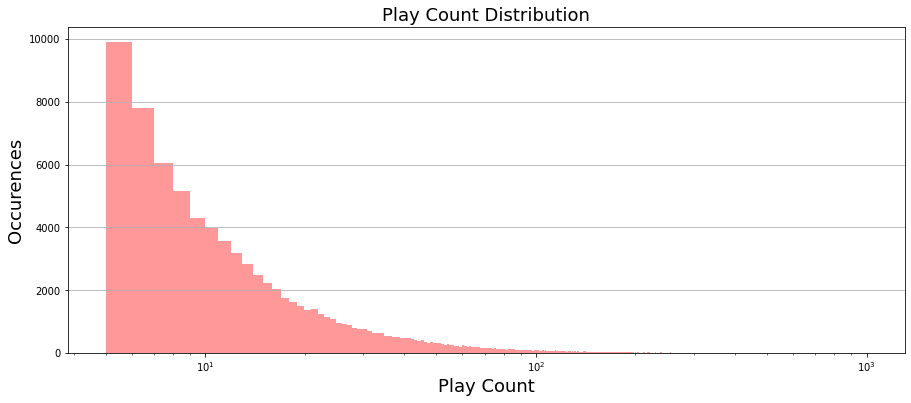

In [27]:
plt.subplots(figsize=(15, 6))
sns.distplot(subset_pd.plays, bins = 1000, kde = False, color='red')
plt.grid(which="major", axis="y")
plt.xlabel("Play Count", size=18, fontsize=18)
plt.ylabel("Occurences", size=18, fontsize=18)
plt.xscale('log')
plt.title("Play Count Distribution", size=18, fontsize=18);

We see an exponential decrease in the play count distribution.

The following command checks if there is any null value in the dataset.

In [29]:
subset.select([count(when(isnan(c), c)).alias(c) for c in data.columns]).show()

+------+--------+-----+
|userid|artistid|plays|
+------+--------+-----+
|     0|       0|    0|
+------+--------+-----+



In [30]:
subset.printSchema()

root
 |-- userid: integer (nullable = true)
 |-- artistid: integer (nullable = true)
 |-- plays: integer (nullable = true)



In [31]:
artists.show()

+--------+--------------------+
|artistid|                name|
+--------+--------------------+
| 1134999|        06Crazy Life|
| 6821360|        Pang Nakarin|
|10113088|Terfel, Bartoli- ...|
|10151459| The Flaming Sidebur|
| 6826647|   Bodenstandig 3000|
|10186265|Jota Quest e Ivet...|
| 6828986|       Toto_XX (1977|
|10236364|         U.S Bombs -|
| 1135000|artist formaly kn...|
|10299728|Kassierer - Musik...|
|10299744|         Rahzel, RZA|
| 6864258|      Jon Richardson|
| 6878791|Young Fresh Fello...|
|10299751|          Ki-ya-Kiss|
| 6909716|Underminded - The...|
|10435121|             Kox-Box|
| 6918061|  alexisonfire [wo!]|
| 1135001|         dj salinger|
| 6940391|The B52's - Chann...|
|10475396|             44 Hoes|
+--------+--------------------+
only showing top 20 rows



In [32]:
artists.describe().show()

+-------+-----------------+---------------+
|summary|         artistid|           name|
+-------+-----------------+---------------+
|  count|          1848281|        1848295|
|   mean|7028265.171776369|            NaN|
| stddev| 3753055.54540281|            NaN|
|    min|                1|              |
|    max|         10794305|￿￿￿￿￿￿￿￿￿￿￿￿くȁ|
+-------+-----------------+---------------+



Some artists have mispelled or complex names. For example, if we take the artist name "John Coltrane", we find the number of distinct occurrences. We can see it repeats itself various times having different IDs, which may bias our predictions.

In [33]:
artists.createOrReplaceTempView("artists")
sqlDF = spark.sql("SELECT * FROM artists where name like '%John Coltrane%'")

In [34]:
DFP = sqlDF.distinct().toPandas()
DFP.head(10)

,artistid,name
0,10590286,"Miles Davis, John Coltrane & Cannonball Adderley"
1,1276695,"Miles Davis, Cannonball Adderley, John Coltran..."
2,1281076,"Thelonious Monk, John Coltrane, Wilbur Ware"
3,10488903,John Coltrane-Giant Steps
4,10489679,The John Coltrane Sextet
5,10117215,John Coltrane w/Thelonius Monk
6,1312936,John Coltrane Live at Birdland
7,10642215,John Coltrane and Frank Wess
8,10643478,Miles Davis Quintet Feat. John Coltrane
9,1201020,Cannonball Adderley and John Coltrane -02


In [35]:
sqlDF.distinct().count()

414

In the following exemple, the artistID = 360 corresponds to a correct artist name (standing for "John Coltrane"). Mispelled artist ID are stored in the variable named 'aliases'. So, as an exemple, **artistID = 1244643 is mispelled and corresponds to artistID = 360**

In [36]:
artists[artists.artistid==1244643].show()
artists[artists.artistid==360].show()

+--------+----------------+
|artistid|            name|
+--------+----------------+
| 1244643|03 John Coltrane|
+--------+----------------+

+--------+-------------+
|artistid|         name|
+--------+-------------+
|     360|John Coltrane|
+--------+-------------+



In [37]:
aliases[aliases.mispelledid==1244643].show()
aliases[aliases.mispelledid==360].show()

+-----------+--------+
|mispelledid|artistid|
+-----------+--------+
|    1244643|     360|
+-----------+--------+

+-----------+--------+
|mispelledid|artistid|
+-----------+--------+
+-----------+--------+



The misspelled artist ID are replaced by the correct ones.

In [38]:
id1=1244643

In [39]:
subset[subset.artistid==id1].collect()
strangeuserid = subset[subset.artistid==id1].userid
strangeUserActivity = subset[subset.userid==strangeuserid]
artists = strangeUserActivity.join(artists, on = "artistid")

In [40]:
artists[artists.artistid==360].show()
artists[artists.artistid==1244643].show()

+--------+-------+-----+-------------+
|artistid| userid|plays|         name|
+--------+-------+-----+-------------+
|     360|1000002|    5|John Coltrane|
|     360|1000082|   11|John Coltrane|
|     360|1000102|   32|John Coltrane|
|     360|1000105|    6|John Coltrane|
|     360|1000107|   35|John Coltrane|
|     360|1000111|    6|John Coltrane|
|     360|1000119|   17|John Coltrane|
|     360|1000127|   11|John Coltrane|
|     360|1000176|   53|John Coltrane|
|     360|1000178|   13|John Coltrane|
|     360|1000224|   12|John Coltrane|
|     360|1000258|   43|John Coltrane|
|     360|1000259|   58|John Coltrane|
|     360|1000274|   10|John Coltrane|
|     360|1000301|   98|John Coltrane|
|     360|1000307|    7|John Coltrane|
|     360|1000327|   16|John Coltrane|
|     360|1000390|    7|John Coltrane|
|     360|1000395|   20|John Coltrane|
|     360|1000428|   21|John Coltrane|
+--------+-------+-----+-------------+
only showing top 20 rows

+--------+------+-----+----+
|artistid

In [41]:
subset = artists
subset.describe().show()

+-------+------------------+------------------+-----------------+--------------+
|summary|          artistid|            userid|            plays|          name|
+-------+------------------+------------------+-----------------+--------------+
|  count|           9306376|           9306376|          9306376|       9306168|
|   mean|1319277.8503197164|1939115.8133319565|33.87218537054596|      Infinity|
| stddev| 2015061.840234866|490788.62697331404|66.61000116270195|           NaN|
|    min|                 1|                90|                5|            Z|
|    max|          10794235|           2443507|             1000|￾氀挀 渀䌀愀渀|
+-------+------------------+------------------+-----------------+--------------+



In order to approach a normalized distribution, we use a log transformation of the variable to explain.

In [42]:
subset = subset.withColumn("log_plays",log1p("plays"))

In [43]:
subset_pd = subset.sample(withReplacement=False, fraction=0.01, seed=42).toPandas()

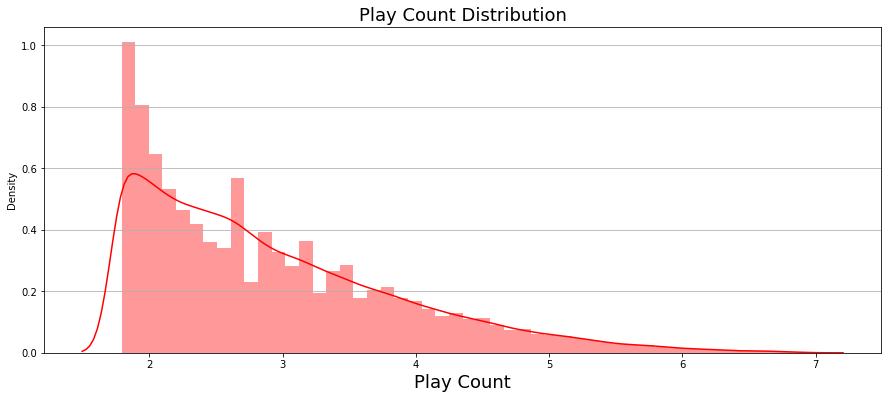

In [44]:
plt.subplots(figsize=(15, 6))
sns.distplot(subset_pd.log_plays, color='red')
plt.grid(which="major", axis="y")
plt.xlabel("Play Count", size=14, fontsize=18)
plt.title("Play Count Distribution", size=16, fontsize=18);

### More Database exploration

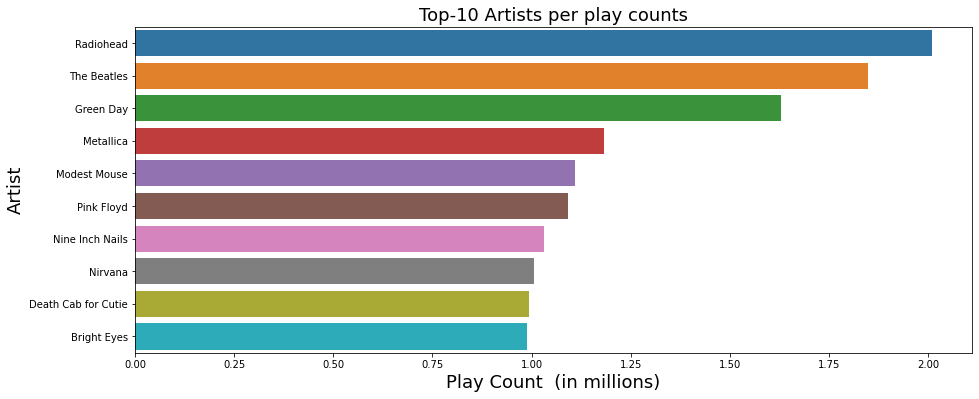

In [70]:
top10ArtistsPC = subset.groupBy("name").sum("plays").orderBy('sum(plays)', ascending=0).take(10)
top10ArtistsPC = pd.DataFrame(data=top10ArtistsPC)

plt.subplots(figsize=(15, 6))
sns.barplot(x=top10ArtistsPC[1]/1000000, y=top10ArtistsPC[0])
plt.xlabel('Play Count  (in millions)', fontsize=18)
plt.ylabel('Artist', fontsize=18)
plt.title('Top-10 Artists per play counts', fontsize=18);

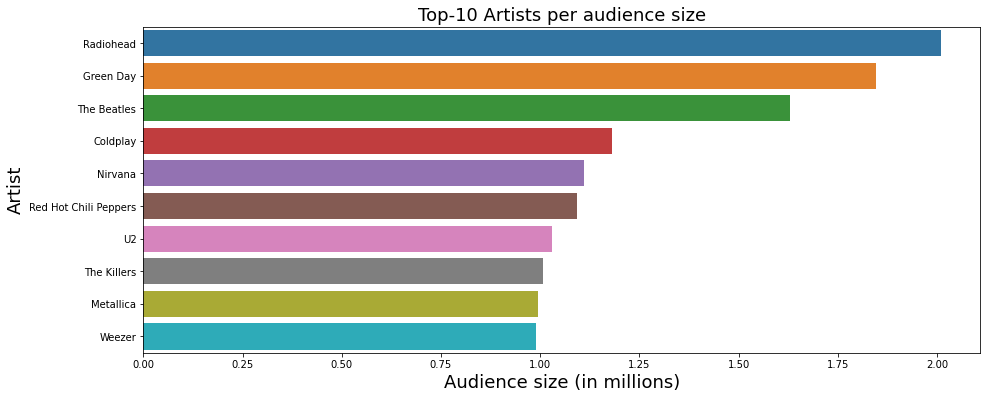

In [71]:
top10ArtistsUC = (subset.dropDuplicates(['userid', 'artistid']).groupBy("name").count().orderBy("count", ascending=0).take(10))
top10ArtistsUC = pd.DataFrame(top10ArtistsUC)

plt.subplots(figsize=(15, 6))
sns.barplot(x=top10ArtistsPC[1]/1000000, y=top10ArtistsUC[0])
plt.xlabel('Audience size (in millions)', fontsize=18)
plt.ylabel('Artist', fontsize=18)
plt.title('Top-10 Artists per audience size', fontsize=18);

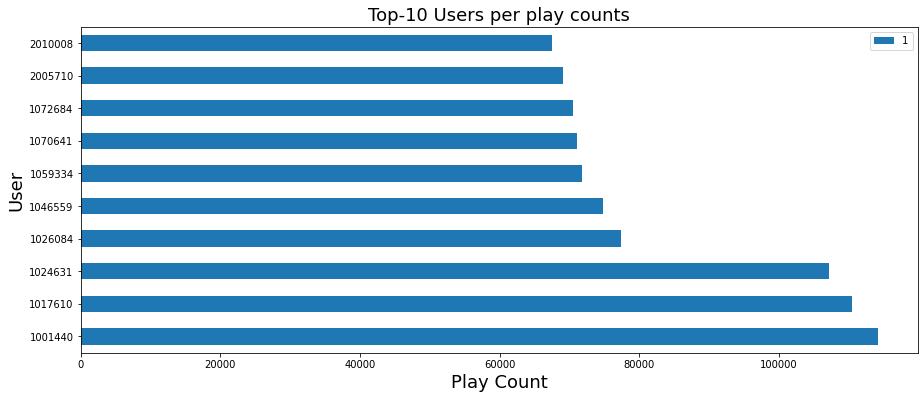

In [72]:
# calculate top 10 users interm of play counts
top10UsersByPlayCount = subset.groupBy("userid").sum("plays").orderBy('sum(plays)', ascending=0).take(10)
top10UsersByPlayCount = pd.DataFrame(top10UsersByPlayCount)
top10UsersByPlayCount[0] = top10UsersByPlayCount[0].astype(str)
topusers = top10UsersByPlayCount[0].astype(str)
top10UsersByPlayCount[0] = pd.DataFrame(topusers)
top10UsersByPlayCount.set_index(topusers.sort_values(ascending=True), inplace=True)
top10UsersByPlayCount.drop(columns=0)

top10UsersByPlayCount.plot(kind='barh', figsize=(15,6))
plt.xlabel('Play Count', fontsize=18)
plt.ylabel('User', fontsize=18)
plt.title('Top-10 Users per play counts', fontsize=18);

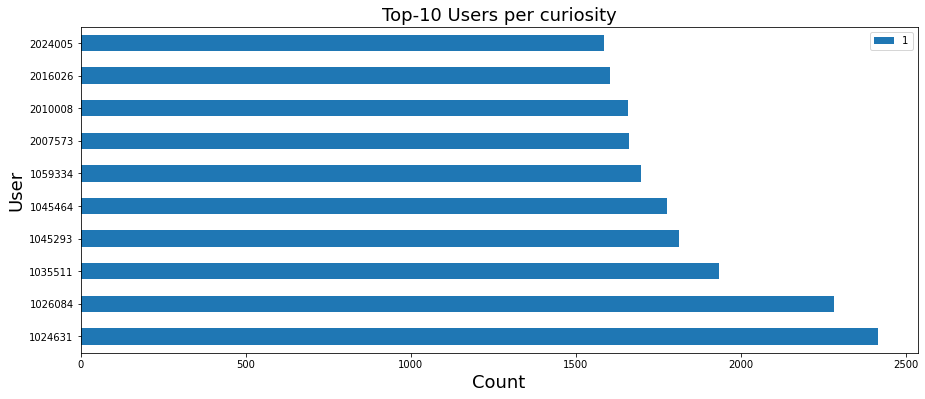

In [73]:
# calculate top 10 users interm of curiosity
top10UsersByCuriosity = (subset.dropDuplicates(['userid', 'name'])
                          .groupBy(str("userid"))
                          .count()
                          .orderBy("count", ascending=0)
                          .take(10))

top10UsersByCuriosity = pd.DataFrame(top10UsersByCuriosity)

top10UsersByCuriosity[0] = top10UsersByCuriosity[0].astype(str)
topusers = top10UsersByCuriosity[0].astype(str)
top10UsersByCuriosity[0] = pd.DataFrame(topusers)
top10UsersByCuriosity.set_index(topusers.sort_values(ascending=True), inplace=True)
top10UsersByCuriosity.drop(columns=0)

top10UsersByCuriosity.plot(kind='barh', figsize=(15,6))
plt.xlabel('Count', fontsize=18)
plt.ylabel('User', fontsize=18)
plt.title('Top-10 Users per curiosity', fontsize=18);

### Empirical Cumulative Distribution Function (ECDF) of the number of play counts per user

In [157]:
def showECDF(DF, tag):
    df = DF.to_frame().sort_values(by=['playCount']).reset_index() 
    percentiles = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

    print(df.quantile(percentiles)) #show the quantiles

    # Set up the plotting value - X-axis and Y-axis
    XX = df['playCount']
    YY = np.arange(len(XX))/float(len(XX))

    #set up the value of each quantiles 
    per = [10, 25, 50, 75, 90]
    colors = ['royalblue','mediumblue','darkblue','navy','black']
    rank = [int(x / 100 * (len(YY) + 1)) for x in per]
    rplot = [YY[x] for x in rank]
    pervalues_users = [XX[x] for x in rank]

    plt.figure(figsize=(12, 6))

    # The ECDF plot
    ax = plt.subplot()
    ax.set_xscale("log")
    plt.plot(XX, YY)

    # plot the percentiles 
    plt.scatter(pervalues_users,
            rplot, 
            c = colors,
            marker = 'o')
    ax.vlines(pervalues_users, [0], rplot, color=colors, linestyle='--')
    ax.hlines(rplot, [0], pervalues_users, color=colors, linestyle='--')
    for i in range(len(rplot)):
        ax.annotate("  " + str(pervalues_users[i]), (pervalues_users[i], rplot[i]))
    
    plt.xlabel('Play Counts in log')
    plt.ylabel('Empirical Cumulative Distribution Function')
    plt.grid(True,which="both",ls="-")
    plt.title('Empirical Cumulative Distribution Function of number of play counts per User ID')
    plt.show()
    
    for p in percentiles:
        i = np.where(YY<=p)[0][-1]
        print(str(p*100), "percent of the " + tag + " has less than: ", XX[i], " play counts")
    
    return df

        userID  playCount
0.1  1054516.0       34.0
0.2  2020723.0      132.0
0.3  2071735.0      293.0
0.4  2137074.0      535.0
0.5  2206106.0      892.0
0.6  2271597.0     1415.0
0.7  2321177.0     2226.0
0.8  2370413.0     3584.0
0.9  2413179.0     6484.0
1.0  2443548.0   674412.0


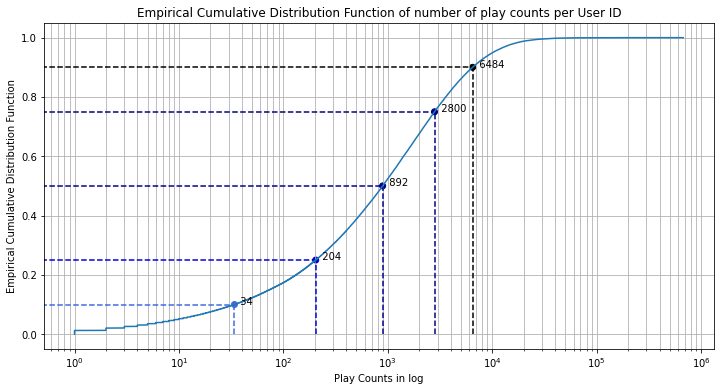

10.0 percent of the users has less than:  34  play counts
20.0 percent of the users has less than:  132  play counts
30.0 percent of the users has less than:  293  play counts
40.0 percent of the users has less than:  535  play counts
50.0 percent of the users has less than:  892  play counts
60.0 percent of the users has less than:  1415  play counts
70.0 percent of the users has less than:  2226  play counts
80.0 percent of the users has less than:  3584  play counts
90.0 percent of the users has less than:  6484  play counts
100.0 percent of the users has less than:  674412  play counts


In [158]:
df = showECDF(userActivity, 'users')

       artistID  playCount
0.1   1271524.7        1.0
0.2   2115843.4        1.0
0.3   6718025.1        1.0
0.4   6905141.8        2.0
0.5   9948696.5        3.0
0.6  10121984.2        5.0
0.7  10293356.9        8.0
0.8  10458623.6       15.0
0.9  10625203.3       45.0
1.0  10794401.0  2502130.0


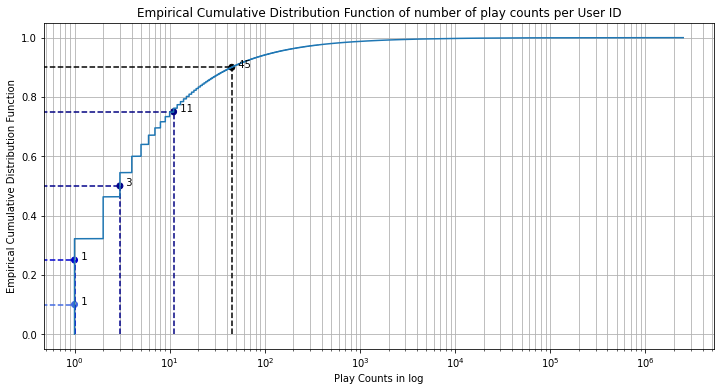

10.0 percent of the artists has less than:  1  play counts
20.0 percent of the artists has less than:  1  play counts
30.0 percent of the artists has less than:  1  play counts
40.0 percent of the artists has less than:  2  play counts
50.0 percent of the artists has less than:  3  play counts
60.0 percent of the artists has less than:  5  play counts
70.0 percent of the artists has less than:  8  play counts
80.0 percent of the artists has less than:  15  play counts
90.0 percent of the artists has less than:  45  play counts
100.0 percent of the artists has less than:  2502130  play counts


In [159]:
df = showECDF(artistPopularity, 'artists')

### Modeling of a Recommender System

In [45]:
train, test = subset.randomSplit([0.8, 0.2], seed=42)

In [47]:
%%time
als = ALS(maxIter=5, regParam=0.01, userCol='userid', itemCol='artistid', ratingCol='log_plays')

CPU times: user 2.04 ms, sys: 199 µs, total: 2.24 ms
Wall time: 60.7 ms


In [48]:
%%time
model = als.fit(train)

CPU times: user 20.7 ms, sys: 4.55 ms, total: 25.2 ms
Wall time: 1min 1s


In [49]:
%%time
predictions = model.transform(test)

CPU times: user 4.48 ms, sys: 0 ns, total: 4.48 ms
Wall time: 42.4 ms


In [50]:
%%time
predictions.count()

CPU times: user 6.66 ms, sys: 1.12 ms, total: 7.78 ms
Wall time: 33.5 s


1862407

After a log transformation, it can be expected undefined values in the variable to explain. So we drop those missing values.

In [51]:
predictions = predictions.dropna(subset=('prediction'))

In [52]:
%%time
predictions.count()

CPU times: user 6.18 ms, sys: 822 µs, total: 7 ms
Wall time: 32.6 s


1784742

In [53]:
predictions.show()

+--------+-------+-----+--------------------+------------------+----------+
|artistid| userid|plays|                name|         log_plays|prediction|
+--------+-------+-----+--------------------+------------------+----------+
|      22|1051976|   11| Nocturnal Emissions|2.4849066497880004| 4.8125906|
|      22|1062894|   37| Nocturnal Emissions|3.6375861597263857|  5.211503|
|      22|1031888|   64| Nocturnal Emissions| 4.174387269895637| 5.1426992|
|      22|2059316|   75| Nocturnal Emissions| 4.330733340286331|  4.397157|
|      22|2233968|    7| Nocturnal Emissions|2.0794415416798357| 3.0022397|
|      23|2213999|   18|Utah Philips & An...|2.9444389791664403| 2.0239415|
|      23|2009983|   16|Utah Philips & An...| 2.833213344056216| 1.7795602|
|      23|2380458|   27|Utah Philips & An...| 3.332204510175204| 2.8886008|
|      23|2418208|    5|Utah Philips & An...| 1.791759469228055| 2.0471003|
|      23|2112919|    7|Utah Philips & An...|2.0794415416798357| 1.5128312|
|      24|10

In [54]:
evaluator_rmse = RegressionEvaluator(metricName='rmse', labelCol='log_plays', predictionCol='prediction')
rmse = evaluator_rmse.evaluate(predictions.na.drop()) 

In [59]:
%%time
als_cv = ALS(userCol='userid', itemCol='artistid', ratingCol='log_plays')
crossval = CrossValidator(estimator=als_cv, estimatorParamMaps=paramGrid, evaluator=evaluator_rmse, numFolds=3)

CPU times: user 2.82 ms, sys: 0 ns, total: 2.82 ms
Wall time: 16.9 ms


In [55]:
evaluator_r2 = RegressionEvaluator(metricName='r2', labelCol='log_plays', predictionCol='prediction')
r2 = evaluator_r2.evaluate(predictions.na.drop())

In [56]:
print('RMSE (Log)')
print(rmse)
print()
print('RMSE')
print(np.expm1(rmse))
print()
print('R Squared')
print(r2)
print()

RMSE (Log)
0.9627434345880047

RMSE
1.6188713292353873

R Squared
0.026777162841328916



In [58]:
paramGrid = ParamGridBuilder().addGrid(als.rank, [1, 5, 10, 20]).addGrid(als.maxIter, [20]).addGrid(als.regParam, [0.001, 0.005, 0.01, 0.1]).build()

In [131]:
%%time
cvModel = crossval.fit(train)

CPU times: user 4.54 s, sys: 926 ms, total: 5.47 s
Wall time: 34min 40s


In [132]:
bestModel = cvModel.bestModel

In [ ]:
%%time
predictions_cv = cvModel.transform(test)

In [62]:
rmse_cv = evaluator_rmse.evaluate(predictions_cv.na.drop())
r2_cv = evaluator_r2.evaluate(predictions_cv.na.drop())

In [63]:
predictions_cv.show()

+--------+-------+-----+--------------------+------------------+----------+
|artistid| userid|plays|                name|         log_plays|prediction|
+--------+-------+-----+--------------------+------------------+----------+
|      22|1051976|   11| Nocturnal Emissions|2.4849066497880004| 2.7286077|
|      22|1062894|   37| Nocturnal Emissions|3.6375861597263857|  3.509797|
|      22|1031888|   64| Nocturnal Emissions| 4.174387269895637|  4.095628|
|      22|2059316|   75| Nocturnal Emissions| 4.330733340286331|  3.255273|
|      22|2233968|    7| Nocturnal Emissions|2.0794415416798357| 2.0271654|
|      23|2213999|   18|Utah Philips & An...|2.9444389791664403| 2.3605373|
|      23|2009983|   16|Utah Philips & An...| 2.833213344056216| 2.3376267|
|      23|2380458|   27|Utah Philips & An...| 3.332204510175204|  2.242085|
|      23|2418208|    5|Utah Philips & An...| 1.791759469228055| 1.7211041|
|      23|2112919|    7|Utah Philips & An...|2.0794415416798357| 1.9957595|
|      24|10

In [64]:
print('RMSE (Log)')
print(rmse_cv)
print()
print('RMSE')
print(np.expm1(rmse_cv))
print()
print('R Squared')
print(r2_cv)

RMSE (Log)
0.864118560572359

RMSE
1.3729135843142566

R Squared
0.21596070931811773


We see the cross-validation helps having lower noise (RMSE decreases) and better predictions (R Squared multiplied by 10).

In [116]:
%%time
# Generate top 10 movie recommendations for each user
userRecs = bestModel.recommendForAllUsers(10)
# Generate top 10 user recommendations for each artist
artistRecs = bestModel.recommendForAllItems(10)

CPU times: user 2.23 ms, sys: 0 ns, total: 2.23 ms
Wall time: 175 ms


In [117]:
%%time
uRP = userRecs.toPandas()
uRP.head()

CPU times: user 10 s, sys: 1.4 s, total: 11.4 s
Wall time: 30min 57s


In [118]:
uRP.head()

,userid,recommendations
0,90,"[(10062241, 7.713888645172119), (10108677, 7.4..."
1,128,"[(10125325, 5.5528059005737305), (6973282, 5.5..."
2,384,"[(10108677, 7.943511486053467), (10198687, 7.6..."
3,536,"[(6973282, 7.298683166503906), (10062241, 6.88..."
4,581,"[(10062241, 7.638814449310303), (10108677, 7.0..."


In [119]:
uRP.to_csv(local_path + "uRP.csv", index=False)

In [68]:
%%time
aRP = artistRecs.toPandas()
aRP.head()

CPU times: user 25.2 s, sys: 2.23 s, total: 27.4 s
Wall time: 32min 2s


In [69]:
aRP

,artistid,recommendations
0,22,"[(2398356, 23.031309127807617), (2191339, 22.8..."
1,23,"[(2023977, 8.984450340270996), (2332209, 8.662..."
2,24,"[(2007444, 9.178375244140625), (2183783, 8.644..."
3,32,"[(2410999, 8.6751708984375), (2160782, 8.49465..."
4,35,"[(1005184, 17.713172912597656), (2267377, 15.3..."
...,...,...
473269,10792305,"[(1009561, 4.29862642288208), (2289228, 4.0810..."
473270,10792489,"[(2269088, 3.4988644123077393), (1009561, 3.42..."
473271,10792935,"[(2289228, 4.142323017120361), (2395813, 4.140..."
473272,10793735,"[(1009561, 4.136872291564941), (2395813, 4.135..."


In [107]:
aRP.to_csv(local_path + "aRP.csv", index=False)

### Predictions

In [169]:
predictions_cv = predictions_cv.withColumn('scaled_prediction',  predictions_cv["prediction"] )

In [170]:
def user_predictions(user):
    single_user = predictions_cv.filter(test["userid"] == user).select(
        ["userid", "name", "scaled_prediction"]
    )
    single_user.withColumn("artist", (single_user["name"])).drop(
        single_user["name"]
    ).orderBy("scaled_prediction", ascending=False).show(truncate=False)

In [171]:
%%time
single_user = predictions_cv.filter(test["userid"] == 1026084).head()

CPU times: user 44.6 ms, sys: 6.97 ms, total: 51.5 ms
Wall time: 27.8 s


In [172]:
single_user

Row(artistid=53, userid=1026084, plays=11, name='Wu-Tang Clan', log_plays=2.4849066497880004, prediction=3.029461622238159, scaled_prediction=3.029461622238159)

In [173]:
%%time
testP = test.select("log_plays").show(5000)

+------------------+
|         log_plays|
+------------------+
|2.4849066497880004|
|   5.4510384535657|
|3.1354942159291497|
|3.8066624897703196|
|6.3561076606958915|
| 1.791759469228055|
|1.9459101490553132|
|2.3978952727983707|
|2.3978952727983707|
|2.0794415416798357|
| 3.367295829986474|
| 5.407171771460119|
|3.7612001156935624|
|2.5649493574615367|
|3.5263605246161616|
| 2.639057329615259|
| 2.302585092994046|
|3.6109179126442243|
|3.4011973816621555|
| 5.805134968916488|
|5.3981627015177525|
|3.6109179126442243|
|5.8888779583328805|
|2.5649493574615367|
|3.7376696182833684|
|1.9459101490553132|
|2.1972245773362196|
|  3.58351893845611|
| 3.044522437723423|
| 3.295836866004329|
|2.9444389791664403|
| 2.833213344056216|
| 2.833213344056216|
|3.1780538303479458|
|2.5649493574615367|
| 4.110873864173311|
| 2.833213344056216|
| 2.639057329615259|
| 2.302585092994046|
|2.0794415416798357|
|3.2188758248682006|
| 2.302585092994046|
|2.8903717578961645|
|2.1972245773362196|
|2.3978952727

In [175]:
predictions_cv["userid", "name", "scaled_prediction"].head(15)

[Row(userid=1051976, name='Nocturnal Emissions', scaled_prediction=2.728607654571533),
 Row(userid=1062894, name='Nocturnal Emissions', scaled_prediction=3.5097970962524414),
 Row(userid=1031888, name='Nocturnal Emissions', scaled_prediction=4.095627784729004),
 Row(userid=2059316, name='Nocturnal Emissions', scaled_prediction=3.2552731037139893),
 Row(userid=2233968, name='Nocturnal Emissions', scaled_prediction=2.027165412902832),
 Row(userid=2213999, name='Utah Philips & Ani DiFranco', scaled_prediction=2.36053729057312),
 Row(userid=2009983, name='Utah Philips & Ani DiFranco', scaled_prediction=2.3376266956329346),
 Row(userid=2380458, name='Utah Philips & Ani DiFranco', scaled_prediction=2.2420849800109863),
 Row(userid=2418208, name='Utah Philips & Ani DiFranco', scaled_prediction=1.7211041450500488),
 Row(userid=2112919, name='Utah Philips & Ani DiFranco', scaled_prediction=1.9957594871520996),
 Row(userid=1000145, name='Zap Mama', scaled_prediction=2.514090061187744),
 Row(user

In [174]:
users = [536, 384, 90, 2025687, 2167000]
for user in users:
    single_user = predictions_cv.filter(test["userid"] == user).head()   
    user_predictions(user)    

+------+-----------------+-----------------------------------------+
|userid|scaled_prediction|artist                                   |
+------+-----------------+-----------------------------------------+
|536   |3.5949423        |The Smiths                               |
|536   |3.4966516        |M.I.A.                                   |
|536   |3.496069         |Aphex Twin                               |
|536   |3.4844973        |Dom dummaste                             |
|536   |3.4393044        |16 Horsepower                            |
|536   |3.4231818        |Elvis Hitler                             |
|536   |3.372198         |Morrissey                                |
|536   |3.339166         |Hans Appelqvist                          |
|536   |3.3087995        |Devo                                     |
|536   |3.2962108        |Front Line Assembly                      |
|536   |3.2717805        |Sepultura                                |
|536   |3.2565274        |Cypress 

### Conclusion

We have introduced a recommender system based on a matrix factorization algorithm. The notebook showed that the ALS algorithm can be used with SPARK providing a large-scale recommendation tool. Good parameters are selected by a cross-validation approach.